# Visualisation and post-processing

In this task, we'll learn how to visualise FESTIM results.

Let's create a 1D simulation.

In [36]:
import festim as F
import numpy as np

my_model = F.Simulation()

my_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 1, num=1000)
)

my_material = F.Material(id=1, D_0=1, E_D=0.2)
my_model.materials = my_material

my_model.traps = F.Trap(k_0=1, E_k=0, p_0=0.1, E_p=0, materials=my_material, density=0.5)


# temperature varying in space and time
my_model.T = F.Temperature(500 + F.x + F.t)


my_model.boundary_conditions = [
    F.DirichletBC(
        surfaces=[1, 2],
        value=1 + F.x,  # 1 in x=0, 2 in x=1
        field=0
        )
]


my_model.settings = F.Settings(
    absolute_tolerance=1e-10,
    relative_tolerance=1e-10,
    final_time=100
    )

my_model.dt = F.Stepsize(0.1, stepsize_change_ratio=1.1, dt_min=1e-5)

We now want to export the temperature, the mobile concentration field, and the total retention (mobile + trapped).

>
> Note: in 1D, to visualise the XDMF files in Paraview, the `checkpoint` argument needs to be `False` (see [#134](https://github.com/RemDelaporteMathurin/FESTIM/issues/134))
>

In [37]:
xdmf_exports = [
    F.XDMFExport(field="solute", filename="hydrogen_concentration.xdmf", checkpoint=False),
    F.XDMFExport(field="retention", filename="retention.xdmf", checkpoint=False),
    F.XDMFExport(field="T", filename="T.xdmf", checkpoint=False),
]

We would also like to visualise the total hydrogen inventory, the particle fluxes at the surfaces, and the average temperature.

In [38]:
derived_quantities = F.DerivedQuantities(
    [
        F.TotalVolume(field="retention", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
        F.AverageVolume(field="T", volume=1)
    ],
    filename="./derived_quantities.csv"
)

my_model.exports = [derived_quantities] + xdmf_exports

In [39]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Ellapsed time so far: 5.3 s


Several files were created.

The XDMF files can be opened in [Paraview](https://www.paraview.org/) for visualisation.

The derived_quantities.csv file can be read in Excel, or programmatically in python.


In [40]:
# load the csv file with numpy
data = np.genfromtxt("derived_quantities.csv", delimiter=",", names=True)

# print the columns names
print(data.dtype.names)

('ts', 'Total_retention_volume_1', 'Flux_surface_1_solute', 'Flux_surface_2_solute', 'Average_T_volume_1')


In [41]:
print(data["ts"])

[   0.1           0.21          0.331         0.4641        0.61051
    0.771561      0.9487171     1.14358881    1.35794769    1.59374246
    1.85311671    2.13842838    2.45227121    2.79749834    3.17724817
    3.59497299    4.05447028    4.55991731    5.11590904    5.72749995
    6.40024994    7.14027494    7.95430243    8.84973268    9.83470594
   10.91817654   12.10999419   13.42099361   14.86309297   16.44940227
   18.1943425    20.11377675   22.22515442   24.54766986   27.10243685
   29.91268053   33.00394859   36.40434344   40.14477779   44.25925557
   48.78518112   53.76369924   59.24006916   65.26407608   71.89048369
   79.17953205   87.19748526   96.01723378  100.        ]


Text(0, 0.5, 'H flux')

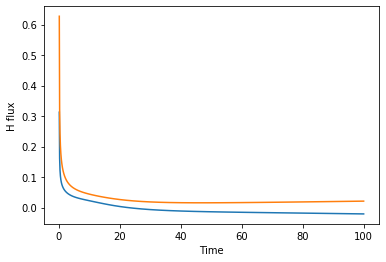

In [43]:
import matplotlib.pyplot as plt

plt.plot(data["ts"], data["Flux_surface_1_solute"])
plt.plot(data["ts"], data["Flux_surface_2_solute"])

plt.xlabel("Time")

plt.ylabel("H flux")

Alternatively, one can use the `plot` function of FEniCS to plot fields directly.

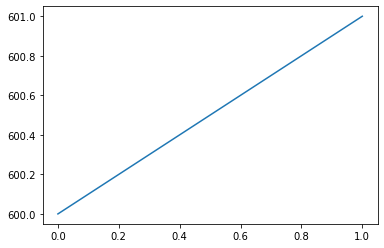

In [44]:
from fenics import plot

plot(my_model.T.T)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


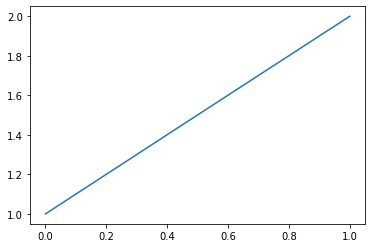

In [45]:
plot(my_model.h_transport_problem.mobile.solution)